# Setup

In [1]:
from utils import *

# Prepare data

## Zones

In [2]:
indy_counties = ('Boone', 'Brown', 'Hamilton', 'Hancock', 'Hendricks', 'Johnson',
                 'Marion', 'Madison', 'Madison', 'Morgan', 'Shelby', 'Tipton')

In [3]:
zones = (
    pd.read_parquet(DATA / 'zones/in_2020.parquet', columns=[
        'geoid', 'scale', 'county', 'aland', 'geometry'])
    .pipe(lambda df: df[df.county.isin(indy_counties)])
    .merge(pd.read_parquet(DATA / 'ses/ses.parquet', columns=['geoid', 'popu']))
    .assign(pop_density=lambda df: df.popu / df.pop('aland'))
).disp()

1,918 rows x 6 cols; Memory: 0.3 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,geometry,popu,pop_density
,<object>,<category>,<category>,<geometry>,<float32>,<float32>
0,18011,County,Boone,"POLYGON ((-9613079.230266 4854909.530626, -961...",69839.0,165.150742


## SES category

In [4]:
ses = pd.read_parquet(DATA / 'ses/acs/acs_2021.parquet')
ses = zones[['geoid']].merge(ses)
ses['sedi'] = (ses[['p_poc', 'm_income', 'p_unemploy', 'p_renter', 'm_hhperveh']]
                .apply(lambda x: x.fillna(0).rank(pct=1)).mean(1))
ses['ses'] = pd.cut(ses.sedi, [-1, 0.33, 0.67, 1.1], labels=['High', 'Mid', 'Low'])
ses = ses[['geoid', 'sedi', 'ses']].disp()

1,918 rows x 3 cols; Memory: 0.1 MiB


,geoid,sedi,ses
,<object>,<float64>,<category>
0,18011,0.397445,Mid


## Opportunities

In [5]:
opport = (pd.read_parquet(DATA / 'access/opport/opportunities.parquet')
          .merge(zones['geoid'])).disp()

12,908 rows x 5 cols; Memory: 0.9 MiB


,geoid,scale,purpose,kind,opport
,<object>,<category>,<category>,<category>,<int32>
0,18011,County,Work,All,37858


## Travel times

In [6]:
tt = (
    pd.read_parquet(DATA / 'access/distances/gdm_2020.parquet',
                    columns=['scale', 'mode', 'src', 'trg', 'time'])
    .pipe(lambda df: df[df['scale'].isin(['Tract', 'BG'])])
    .merge(zones['geoid'].rename('src'))
    .merge(zones['geoid'].rename('trg'))
    .astype(D(src=CAT, trg=CAT))
    .assign(time=lambda df: df.time / 60)
    .query('time <= 90')
).disp()
tt['scale'] = tt['scale'].cat.remove_unused_categories()

3,299,604 rows x 5 cols; Memory: 57.0 MiB


,scale,mode,src,trg,time
,<category>,<category>,<category>,<category>,<float32>
0,Tract,Transit,18109510900,18109510800,21.799999


### Impedance function params
Taken from the results of `Function parameters.ipynb`.

In [4]:
params = (filt(pd.read_csv('data/impedance_params_single.csv'),
               func='Base exponential', target='Time', variable='β1')
          .query('factor != "Urbanity"').fillna('Overall')).disp(None)

10 rows x 3 cols; Memory: 0.0 MiB


,factor,level,value
,<object>,<object>,<float64>
0,Overall,Overall,0.053918
1,Mode,Drive,0.054819
2,Mode,Transit,0.019987
3,Mode,Walk,0.059946
4,Mode,Bike,0.045774
5,Purpose,Work,0.038162
6,Purpose,Non-work,0.057694
13,SES,Low,0.040708
14,SES,Mid,0.055244


## Compute accessibility

In [8]:
def get_access(scale, opport=opport, tt=tt, ses=ses, params=params):
    beta0 = params.iloc[0].value
    opp_poi = filt(opport, scale=scale, purpose='Non-work')
    tt = tt[tt['scale'] == scale].rename(columns=D(trg='geoid'))
    tt_drive = filt(tt, mode='Drive')
    def f(df, factor, level):
        beta = filt(params, factor=factor, level=level).iloc[0].value
        df['general'] = df.opport * np.exp(-beta0 * df.time)
        df['case'] = df.opport * np.exp(-beta * df.time)
        df = (df.groupby('src', observed=True)
              [['general', 'case']].sum().reset_index())
        return df.assign(factor=factor, level=level)
    res = []
    for mode, df in tt.groupby('mode'):
        res.append(f(df.merge(opp_poi), 'Mode', mode))
    for purp, df in opport.groupby('purpose'):
        # return tt_drive.merge(df)
        # return f(tt_drive.merge(df), 'Purpose', purp)
        res.append(f(tt_drive.merge(df), 'Purpose', purp))
    for ses_cat, df in ses.groupby('ses'):
        res.append(f(opp_poi.merge(df).merge(tt_drive), 'SES', ses_cat))
    df = pd.concat(res).rename(columns=D(src='geoid'))
    df['pct_diff'] = (df.general / (df.case + 1e-6) - 1) * 100
    df.factor, df.level = U.factor(df.factor), U.factor(df.level)
    return df

xs_bg = get_access('BG').disp() # 7s

12,590 rows x 6 cols; Memory: 0.6 MiB


,geoid,general,case,factor,level,pct_diff
,<category>,<float64>,<float64>,<category>,<category>,<float64>
0,180118101001,44.835234,64.116986,Mode,Bike,-30.072768


In [9]:
xs_tr = get_access('Tract').disp()

4,046 rows x 6 cols; Memory: 0.3 MiB


,geoid,general,case,factor,level,pct_diff
,<category>,<float64>,<float64>,<category>,<category>,<float64>
0,18011810100,54.101137,76.227294,Mode,Bike,-29.026555


# Visualize

## SES category

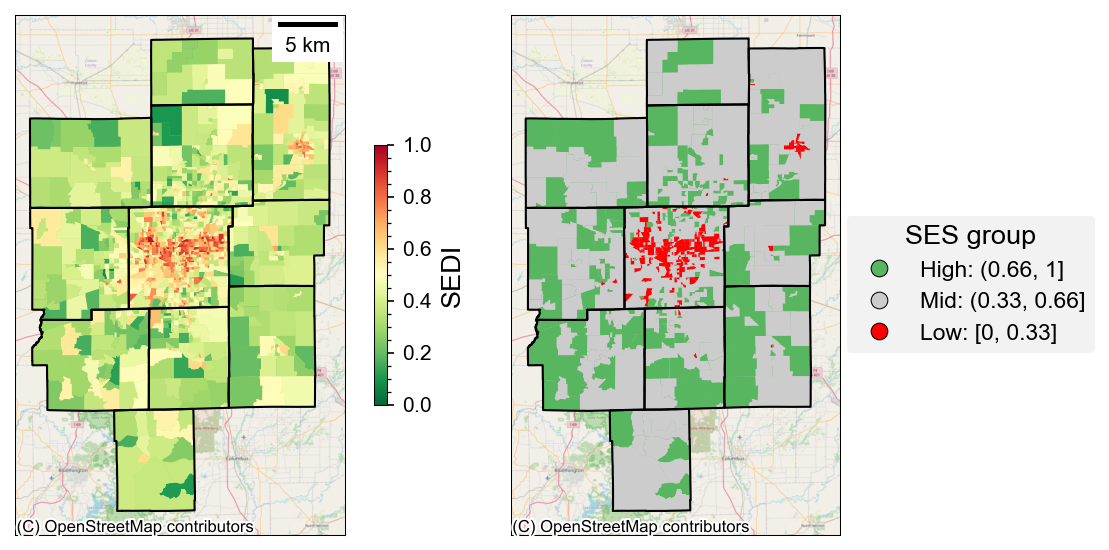

In [10]:
colors = D(High='#57B65F', Mid='#CCC', Low='r')
ses = zones.merge(ses.assign(color=ses.ses.map(colors)))
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), dpi=150,
                                gridspec_kw=D(width_ratios=[1, 0.8]))
maplot(ses, 'sedi', ax1, cmap='RdYlGn_r', vmin=0, vmax=1, label='SEDI')
ses.plot(ax=ax2, color=ses.color)
ctx.add_basemap(ax=ax2, crs=CRS_M, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_xticks([]); ax2.set_yticks([])
ses_labels = ['High: (0.66, 1]', 'Mid: (0.33, 0.66]', 'Low: [0, 0.33]']
ax2.legend(loc=(1.02, 0.35), title='SES group', handles=[
    mpl.lines.Line2D([0], [0], label=x, color='none', marker='o',
                        markerfacecolor=c, markersize=8, markeredgewidth=0.5)
    for x, c in zip(ses_labels, colors.values())])
for ax in (ax1, ax2):
    zones.dissolve('county').plot(ax=ax, fc='none', ec='k')
plt.subplots_adjust(wspace=-0.05)
imsave('SEDI and SES groups of Indianapolis') # 5s

## Access deviation

### Comparison by variable

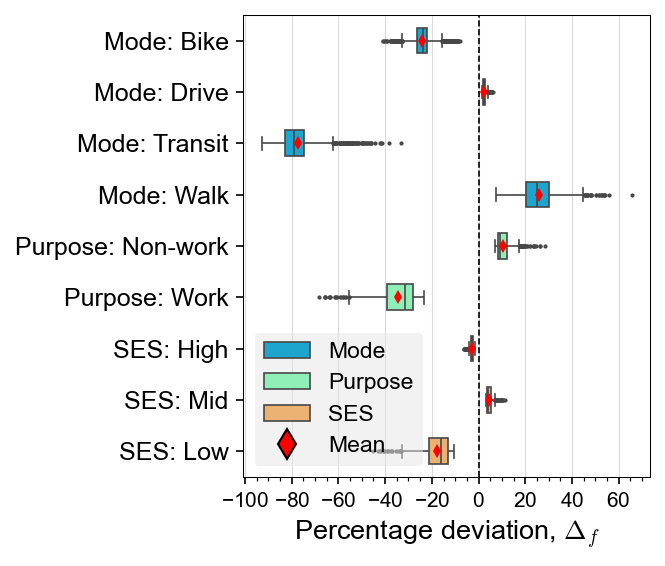

In [11]:
def plot_access_deviation(xs):
    ax = plot(size=(3.5, 4), ylim=(-100, 50), dpi=150, yminor=0)
    df = xs.assign(var=xs.factor.astype(str) + ': ' + xs.level.astype(str))
    sns.boxplot(df, x='pct_diff', y='var', ax=ax, linewidth=0.8,
                width=0.5, fliersize=1, hue='factor', palette='rainbow',
                showmeans=True, meanprops=D(marker='d', markerfacecolor='r',
                                            markersize=5, markeredgecolor='none'))
    ax.yaxis.set_tick_params(labelsize=12)
    ax.axvline(0, ls='--', color='k', lw=0.8)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
    ax.legend(handles=list(ax.legend().legend_handles) + [
        mpl.lines.Line2D([0], [0], color='none', label='Mean',
                        marker='d', markerfacecolor='r', markersize=10)
        ], title='', loc='lower left')
    ax.set_xlabel('Percentage deviation, $\Delta_f$')
    ax.set_ylabel('')
    imsave('Access deviation by using generalized impedance function')
    
plot_access_deviation(xs_bg)

In [12]:
# plot_access_deviation(xs_tr)

### Map for work access and its deviation

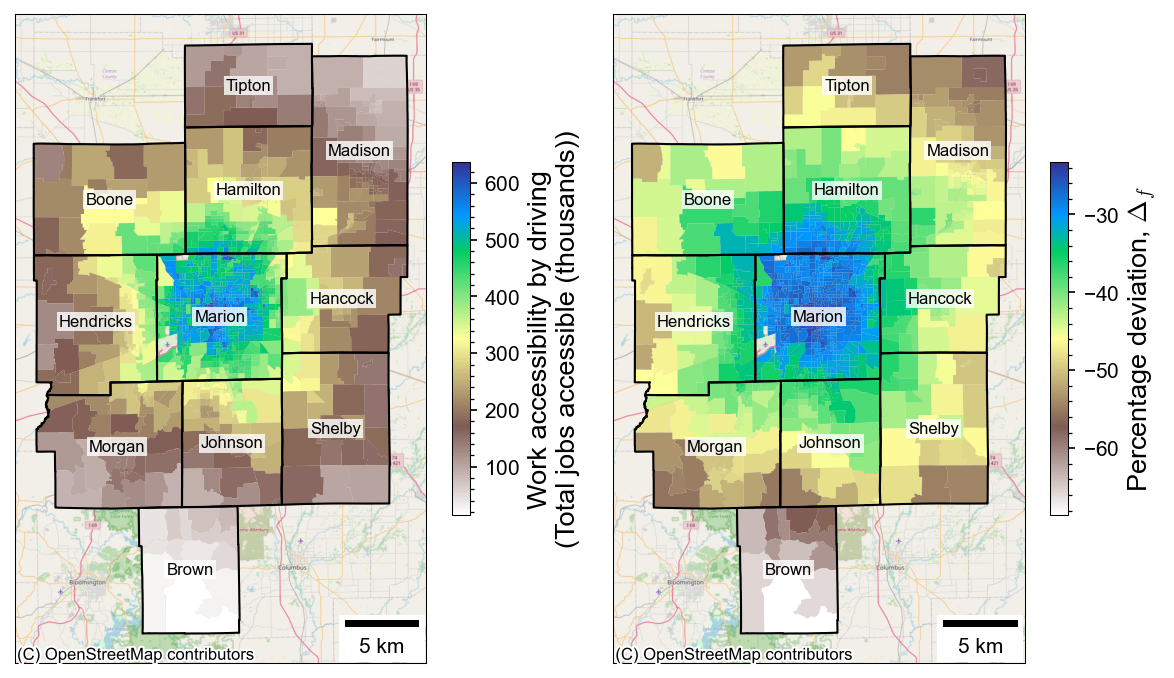

In [13]:
def plot_access_deviation_map(xs):
    _, axes = plt.subplots(1, 2, figsize=(8, 5), dpi=150)
    df = zones.merge(filt(xs, factor='Purpose', level='Work'))
    df['general'] /= 1000
    cnty = zones[['county', 'geometry']].dissolve('county').dropna()
    for ax, (var, label) in zip(axes, [
        ('general', 'Work accessibility by driving\n(Total jobs accessible (thousands))'),
        ('pct_diff', 'Percentage deviation, $\Delta_f$')
    ]):
        df.plot(var, ax=ax, cmap='terrain_r', legend=True,
                legend_kwds=D(label=label, shrink=0.5))
        cnty.plot(ax=ax, fc='none', ec='k', lw=1)
        ctx.add_basemap(ax=ax, crs=CRS_M,
                        source=ctx.providers.OpenStreetMap.Mapnik)
        ax.add_artist(ScaleBar(0.2, location='lower right'))
        for _, r in cnty.iterrows():
            x, y = r.geometry.centroid.coords[0]
            ax.text(x, y, r.name, ha='center', va='center', fontsize=8,
                    bbox=D(fc='w', alpha=0.8, pad=1, ec='none'))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    imsave('Access and its deviation in Indianapolis')
    
plot_access_deviation_map(xs_bg)

In [14]:
# plot_access_deviation_map(xs_tr)

### For other variables

  0%|          | 0/9 [00:00<?, ?it/s]

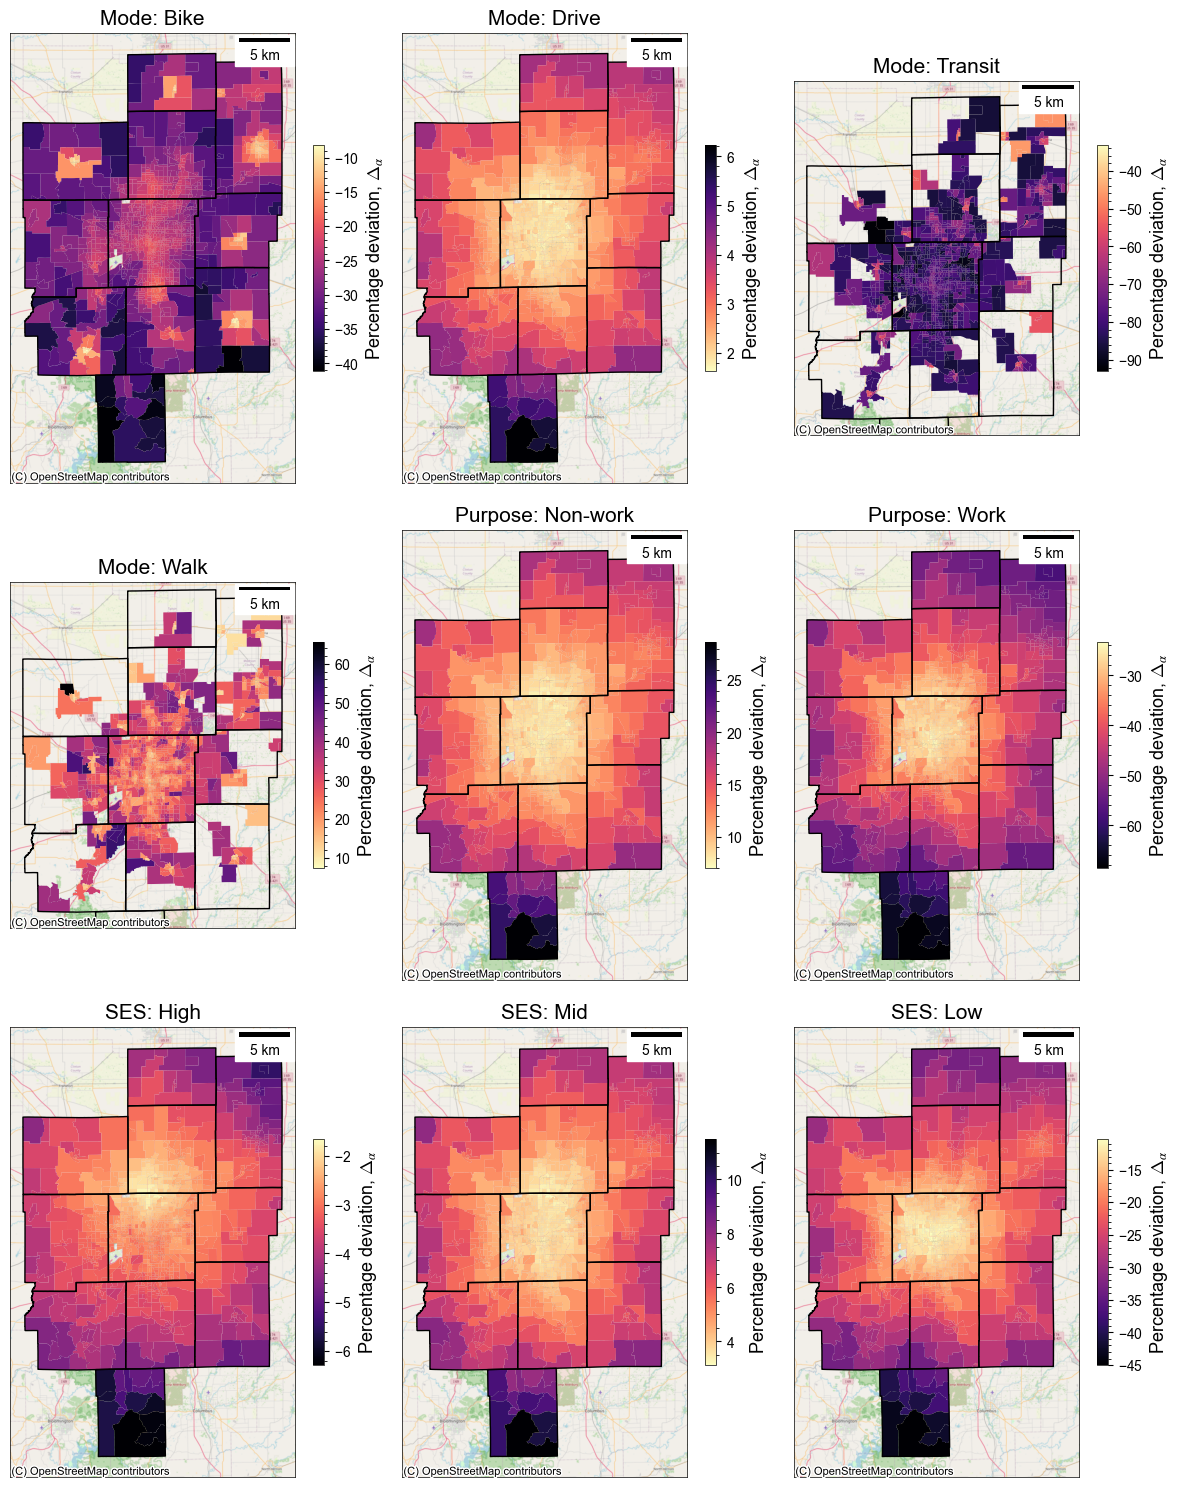

In [15]:
_, axes = plt.subplots(3, 3, figsize=(12, 15), dpi=100)
cnty = zones.dissolve('county')
for i, (level, df) in enumerate(tqdm(xs_bg.groupby('level'))):
    ax = plot(axes.flatten()[i], title=f'{df.factor.iloc[0]}: {level}')
    cmap2 = 'magma' + ('_r' if df.pct_diff.mean() > 0 else '')
    ax = maplot(zones.merge(df), 'pct_diff', ax, cmap=cmap2,
                label='Percentage deviation, $\Delta_α$')
    cnty.plot(ax=ax, fc='none', ec='k', lw=1)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
imsave('Access deviation in Indianapolis by variable') # 33s

### Sensitivity to decay rate

  0%|          | 0/9 [00:00<?, ?it/s]

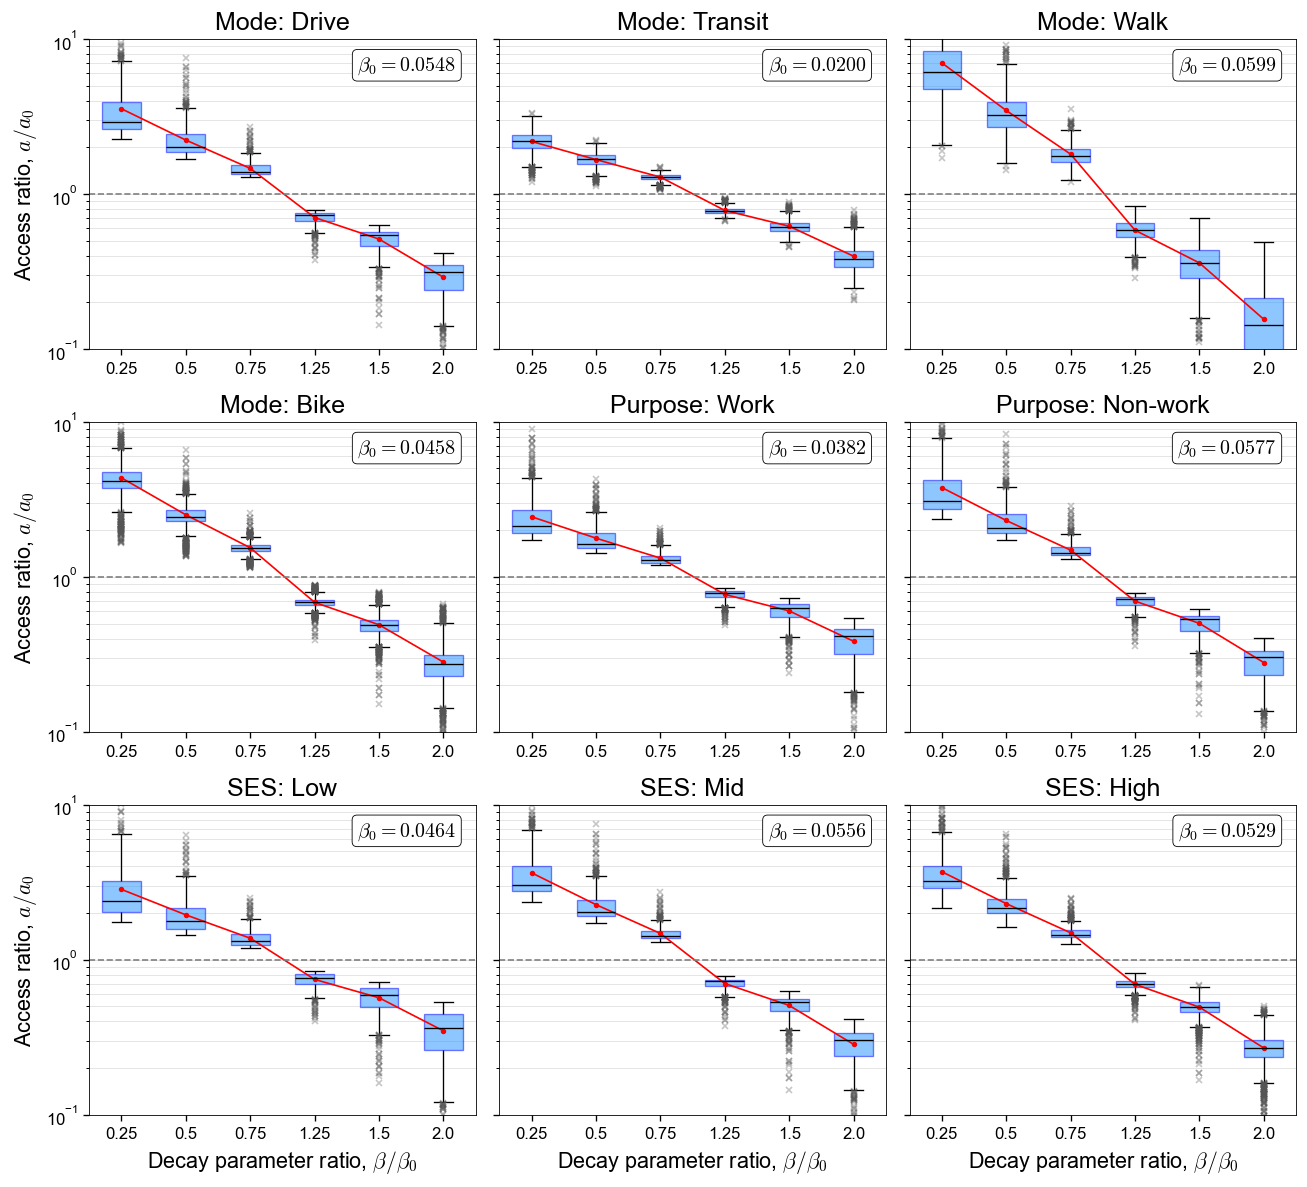

In [16]:
scale = 'BG'
od = filt(zones, scale=scale)[['geoid', 'county']]
od = od[od['county'].isin(set(indy_counties) - {'Brown'})]
od = od.merge(filt(opport, scale=scale)).drop(columns='county')
od = od.merge(filt(ses, scale=scale)[['geoid', 'ses']])
od = od.rename(columns=D(geoid='trg'))
od = filt(tt, scale=scale).merge(od, on='trg')
_, axes = plt.subplots(3, 3, figsize=(11, 10), dpi=120, sharey=True)
for i, r in tqdm(list(params.drop(0).reset_index().iterrows())):
    df = od[od[r.factor.lower()] == r.level]
    if r.factor == 'Mode':
        df = filt(df, purpose='Non-work')
    elif r.factor == 'Purpose':
        df = filt(df, mode='Drive')
    elif r.factor == 'SES':
        df = filt(df, mode='Drive', purpose='Non-work')
    df['base_access'] = df.opport * np.exp(df.time * (-r.value))
    res = []
    for beta_ratio in [.25, .5, .75, 1.25, 1.5, 2]:
        df['access'] = df.opport * np.exp(df.time * (-r.value * beta_ratio))
        xs = df.groupby('src', observed=1)[['base_access', 'access']].sum()
        xs['access_ratio'] = xs.access / xs.base_access
        res.append(xs[['access_ratio']].assign(beta_ratio=beta_ratio))
    df = pd.concat(res)
    ax = plot(axes.flatten()[i], ylog=1, ylim=(0.1, 10), xminor=0)
    sns.boxplot(df, x='beta_ratio', y='access_ratio', ax=ax, width=0.6,
                fliersize=4, linecolor='k', linewidth=0.8,
                boxprops=D(facecolor='dodgerblue', alpha=0.5, edgecolor='b'),
                flierprops=D(marker='x', markeredgecolor='#5555'))
    sns.pointplot(df.groupby('beta_ratio')['access_ratio'].mean().reset_index(),
                  ax=ax, x='beta_ratio', y='access_ratio', color='r', lw=1)
    ax.set_title(r.factor + ': ' + r.level)
    ax.set_xlabel(r"Decay parameter ratio, $\beta/\beta_0$" if i // 3 == 2 else '')
    ax.set_ylabel(r"Access ratio, $a/a_0$" if i % 3 == 0 else '')
    ax.text(0.95, 0.95, r'$\beta_0=%.4f$' % r.value,
            transform=ax.transAxes, ha='right', va='top', fontsize=12,
            bbox=D(boxstyle='round,pad=0.25', facecolor='w',
                   edgecolor='k', linewidth=0.5))
    ax.axhline(1, color='0.5', ls='--', lw=1)
    ax.grid(True, which='both', axis='y', color='.2')
    # break
plt.tight_layout()
imsave('Sensitivity analysis of impedance decay rate') # 18s